In [1]:
import sys
import os
import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
module_path = os.path.join(os.environ['HOME'],'mmc/mmc_github_clones/mmctools/')
#module_path = os.path.join(os.environ['HOME'],'mmc/mmc_github_clones/')                                                          
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from mmctools.windtools.windtools.plotting import plot_timehistory_at_height

# Process FINO1 observation data
High-frequency data shared by Raj on April 8, 2021. Includes velocity and temperature information at 10 Hz during the period of interest.


Regis Thedin

April 2021

In [4]:
# Data path
obspath = '/g/g12/lassman1/mmc/Data/FINO/fino1_sonicData/'

In [5]:
# Times
obsfrom = pd.to_datetime('2010-05-16 00:00:0')
dateto = pd.to_datetime('2010-05-16 06:00:00')

LESfrom=pd.to_datetime('2010-05-16 01:00:00')
LESto=pd.to_datetime('2010-05-16 05:00:00')

## Read files

Some files have timestamps that are not properly defined. As per ISO standard, seconds are zero-padded and go from 0 to 59. The data contained several timestamps are of the form `00:15:60.00`. A workaround for this issue was to replace those round seconds with a ever-so-slightly different time and then round them.

The following command has been executed in the `obspath` directory:
`for file in FINO*; do sed -i 's/\:60.00/\:59.999/g' $file; done`

In [6]:
listOfFiles = np.sort(os.listdir(obspath))
var=['vh','dir','u','v','w','T']
height=[40,60,80]

In [7]:
# Offsets taken from the first 3 lines of the files
offsetdir = {
    40.0: 252.5,
    60.0: 23.5,
    80.0: 11.,
}

In [8]:
datasets=[]
for file in listOfFiles:
    print(file)
    data = pd.read_csv(os.path.join(obspath,file), skiprows=3, sep=' ', parse_dates=[['Date', 'Time']])
    
    # Adjust datetime and interpolate
    data.rename(columns={'Date_Time':'datetime'}, inplace=True)
    
    try:
        #print(data.datetime)
        data['datetime']=data['datetime'].round('0.01S')
    except:
        print("Couldn't round to 0.01S", file)
        continue
    #print(data.datetime)
    data = data.set_index('datetime').resample('0.1S').nearest().interpolate()
    
    # Convert to multiindex dataframe
    newcolumns = []
    for col in data.columns:
        multicol = col.rstrip(')').split('(')
        multicol[1] = float(multicol[1])
        newcolumns.append(multicol)
    data.columns = pd.MultiIndex.from_tuples(newcolumns,
                                             names=[None,'height'])
    data = data.stack()
    
    # Add offsets
    for z,offset in offsetdir.items():
        data.loc[(slice(None),z),'dir'] += offset
            
    datasets.append(data.to_xarray())
    
obs = xr.concat(datasets, dim='datetime')

FINO_MGC__2010_05_16_00_00.txt
FINO_MGC__2010_05_16_00_10.txt
FINO_MGC__2010_05_16_00_20.txt
FINO_MGC__2010_05_16_00_30.txt
FINO_MGC__2010_05_16_00_40.txt
FINO_MGC__2010_05_16_00_50.txt
FINO_MGC__2010_05_16_01_00.txt
FINO_MGC__2010_05_16_01_10.txt
FINO_MGC__2010_05_16_01_20.txt
FINO_MGC__2010_05_16_01_30.txt
FINO_MGC__2010_05_16_01_40.txt
FINO_MGC__2010_05_16_01_50.txt
FINO_MGC__2010_05_16_02_00.txt
FINO_MGC__2010_05_16_02_10.txt
FINO_MGC__2010_05_16_02_20.txt
FINO_MGC__2010_05_16_02_30.txt
FINO_MGC__2010_05_16_02_40.txt
FINO_MGC__2010_05_16_02_50.txt
FINO_MGC__2010_05_16_03_00.txt
FINO_MGC__2010_05_16_03_10.txt
FINO_MGC__2010_05_16_03_20.txt
FINO_MGC__2010_05_16_03_30.txt
FINO_MGC__2010_05_16_03_40.txt
FINO_MGC__2010_05_16_03_50.txt
FINO_MGC__2010_05_16_04_00.txt
FINO_MGC__2010_05_16_04_10.txt
FINO_MGC__2010_05_16_04_20.txt
FINO_MGC__2010_05_16_04_30.txt
FINO_MGC__2010_05_16_04_40.txt
FINO_MGC__2010_05_16_04_50.txt
FINO_MGC__2010_05_16_05_00.txt
FINO_MGC__2010_05_16_05_10.txt
FINO_MGC

## Save data

In [9]:
savepath = '/g/g12/lassman1/mmc/Data/FINO/'

In [10]:
obs = obs.rename({'vh':'wspd', 'dir':'wdir'})

In [11]:
obs.to_netcdf( savepath + 'FINO1_obs_10hz.nc' )

## Plots

In [15]:
obs = xr.open_dataset(savepath +'FINO1_obs_10hz.nc')

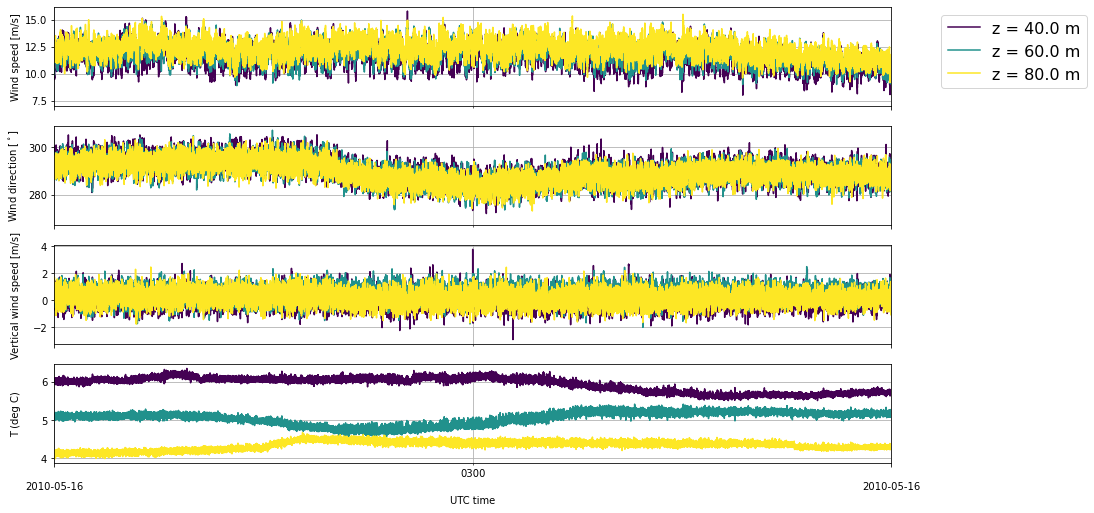

In [16]:
fig,axs = plot_timehistory_at_height(
    obs,
    fields=['wspd','wdir','w','T'],
    heights=[40,60,80],
    cmap='viridis',
    timelimits=[LESfrom,LESto],
    #fieldlimits={'wspd':(11,21),'wdir':(280,310),'theta':(280,283)},
    fieldlabels={'T':'T (deg C)'},
    plot_local_time=False,
    subfigsize=(15,2.1)
)

In [18]:
print(obs.wspd)

<xarray.DataArray 'wspd' (datetime: 216000, height: 3)>
array([[10.318455, 10.654407, 13.392877],
       [10.190436, 10.399297, 13.539759],
       [ 9.955975, 10.224002, 13.36398 ],
       ...,
       [10.124103,  9.057203,  9.713765],
       [10.331704,  8.939241,  9.525565],
       [10.231798,  9.016667,  9.62056 ]])
Coordinates:
  * height    (height) float64 40.0 60.0 80.0
  * datetime  (datetime) datetime64[ns] 2010-05-15T23:50:00 ... 2010-05-16T05...
